Here I'll create a DCGAN following tutorial to generate new characters of "The Simpsons" series. <br>
<img src='https://storage.googleapis.com/kaggle-datasets-images/57177/110068/75eb4611f37901763a2b1847c01e49bc/dataset-cover.jpg?t=2018-09-28-18-23-54'>

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import load_img, array_to_img

2024-02-22 09:54:28.903429: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 09:54:28.903551: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 09:54:29.056418: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
path = '/kaggle/input/simpsons-faces/cropped/'
images = []

In [3]:
IMG_SIZE = 192

In [4]:
for file in os.listdir(path):
    img = Image.open(path + file)
    img = np.asarray(img, dtype='float32')
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    images.append(img)

In [5]:
images = np.array(images)
images.shape

(9877, 192, 192, 3)

In [6]:
images = (images - 127.5) / 127.5

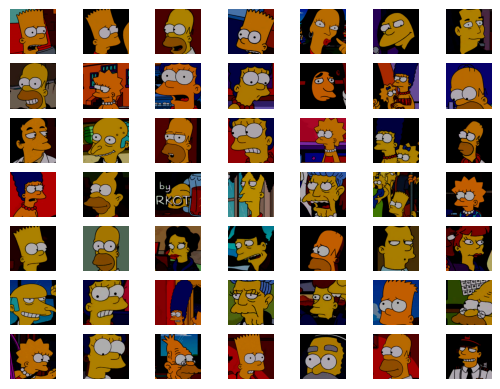

In [7]:
for i in range(49):
    plt.subplot(7, 7, i + 1)
    plt.axis('off')
    plt.imshow(images[i]);

In [8]:
images.max() + images.min()

0.0

In [9]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

In [10]:
LATENT_DIM = 100

Generator

In [11]:
model = Sequential(name='generator')

model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
model.add(layers.ReLU())
model.add(layers.Reshape((8, 8, 512)))

model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same'))
model.add(layers.ReLU())

model.add(layers.Conv2DTranspose(128, (3, 3), strides=(3, 3), padding='same'))
model.add(layers.ReLU())

model.add(layers.Conv2DTranspose(64, (4, 4), strides=(4, 4), padding='same'))
model.add(layers.ReLU())

model.add(layers.Conv2D(3, (4, 4), padding='same', activation='tanh'))

In [12]:
generator = model
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             3309568   
                                                                 
 re_lu (ReLU)                (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 256)       2097408   
 anspose)                                                        
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 48, 48, 128)       295040    
 Transpose)                                              

# Discriminator

In [13]:
model = Sequential(name='discriminator')
input_shape = (IMG_SIZE, IMG_SIZE, 3)
alpha = 0.2

model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Flatten())
model.add(layers.Dropout(0.3))

model.add(layers.Dense(1, activation='sigmoid'))
discriminator = model
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        3136      
                                                                 
 batch_normalization (Batch  (None, 96, 96, 64)        256       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 128)       131200    
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 48, 48, 128)     

# Combine it all to DCGAN

In [14]:
class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')
        
    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]
    
    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn
        
    def train_step(self, real_images):
        # get batch size from the data
        batch_size = tf.shape(real_images)[0]
        # generate random noise
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        # train the discriminator with real (1) and fake (0) images
        with tf.GradientTape() as tape:
            # compute loss on real images
            pred_real = self.discriminator(real_images, training=True)
            # generate real image labels
            real_labels = tf.ones((batch_size, 1))
            # label smoothing
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)
            
            # compute loss on fake images
            fake_images = self.generator(random_noise)
            pred_fake = self.discriminator(fake_images, training=True)
            # generate fake labels
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)
            
            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake) / 2
            
        # compute discriminator gradients
        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # update the gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))
        
        
        # train the generator model
        labels = tf.ones((batch_size, 1))
        # generator want discriminator to think that fake images are real
        with tf.GradientTape() as tape:
            # generate fake images from generator
            fake_images = self.generator(random_noise, training=True)
            # classify images as real or fake
            pred_fake = self.discriminator(fake_images, training=True)
            # compute loss
            g_loss = self.loss_fn(labels, pred_fake)
            
        # compute gradients
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        # update the gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))
        
        # update states for both models
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        
        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}

In [15]:
class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_imgs=9, latent_dim=100):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        
        self.noise = tf.random.normal((num_imgs, latent_dim))
        
    def on_epoch_end(self, epoch, logs=None):
        g_img = self.model.generator(self.noise)
        g_img = (g_img * 127.5) + 127.5
        g_img.numpy()
        
        if epoch % 10 == 0:
            fig = plt.figure(figsize=(8, 8))
            for i in range(self.num_imgs):
                plt.subplot(3, 3, i+1)
                img = array_to_img(g_img[i])
                plt.imshow(img)
                plt.axis('off')
            # plt.savefig('epoch_{:03d}.png'.format(epoch))
            plt.show()
        
    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

In [16]:
dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim=LATENT_DIM)

In [17]:
D_LR = 0.0001
G_LR = 0.0003

dcgan.compile(
    g_optimizer=Adam(learning_rate=G_LR),
    d_optimizer=Adam(learning_rate=D_LR),
    loss_fn=BinaryCrossentropy()
)

Epoch 1/50


I0000 00:00:1708595772.013358      97 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


309/309 [==============================] - 41s 132ms/step - d_loss: 0.0304 - g_loss: 6.7285
Epoch 3/50
309/309 [==============================] - 41s 132ms/step - d_loss: -0.2295 - g_loss: 7.0438
Epoch 4/50
309/309 [==============================] - 41s 132ms/step - d_loss: -0.2035 - g_loss: 9.6703
Epoch 5/50
309/309 [==============================] - 41s 132ms/step - d_loss: -0.1162 - g_loss: 10.3248
Epoch 6/50
309/309 [==============================] - 41s 132ms/step - d_loss: -0.3670 - g_loss: 12.5903
Epoch 7/50
309/309 [==============================] - 41s 132ms/step - d_loss: 0.0608 - g_loss: 8.5623
Epoch 8/50
309/309 [==============================] - 41s 132ms/step - d_loss: 0.0223 - g_loss: 7.3075
Epoch 9/50
309/309 [==============================] - 41s 132ms/step - d_loss: -0.3594 - g_loss: 11.3597
Epoch 10/50
309/309 [==============================] - 41s 132ms/step - d_loss: 0.1358 - g_loss: 10.2363
Epoch 11/50
309/309 [==============================] - ETA: 0s - d_loss: 0

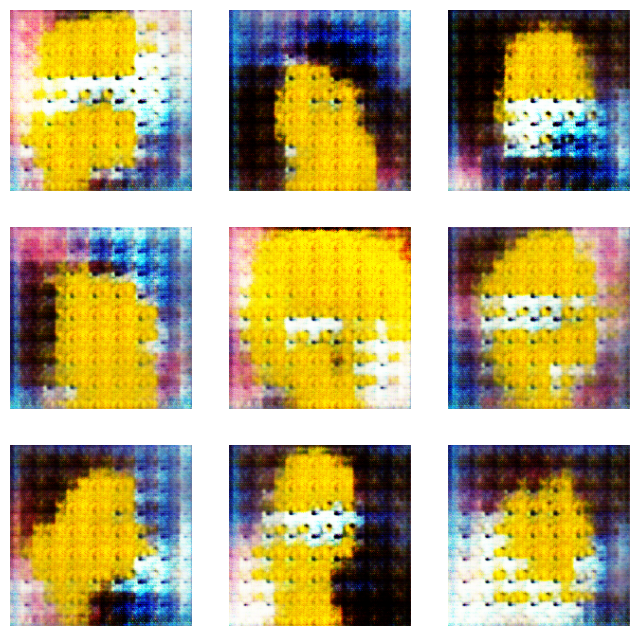

309/309 [==============================] - 41s 134ms/step - d_loss: 0.0191 - g_loss: 7.8066
Epoch 12/50
309/309 [==============================] - 41s 133ms/step - d_loss: 0.0637 - g_loss: 7.8278
Epoch 13/50
309/309 [==============================] - 41s 133ms/step - d_loss: 0.0444 - g_loss: 7.8962
Epoch 14/50
309/309 [==============================] - 41s 133ms/step - d_loss: 0.0629 - g_loss: 8.0491
Epoch 15/50
309/309 [==============================] - 41s 133ms/step - d_loss: 0.1759 - g_loss: 7.2965
Epoch 16/50
309/309 [==============================] - 41s 133ms/step - d_loss: 0.3073 - g_loss: 6.4931
Epoch 17/50
309/309 [==============================] - 41s 133ms/step - d_loss: 0.2062 - g_loss: 6.6536
Epoch 18/50
309/309 [==============================] - 41s 133ms/step - d_loss: 0.1989 - g_loss: 6.1758
Epoch 19/50
309/309 [==============================] - 41s 133ms/step - d_loss: 0.2121 - g_loss: 5.9418
Epoch 20/50
309/309 [==============================] - 41s 133ms/step - d_lo

309/309 [==============================] - 41s 134ms/step - d_loss: 0.2752 - g_loss: 5.9155
Epoch 22/50
309/309 [==============================] - 41s 132ms/step - d_loss: 0.2328 - g_loss: 5.7480
Epoch 23/50
309/309 [==============================] - 41s 132ms/step - d_loss: 0.2022 - g_loss: 5.4303
Epoch 24/50
309/309 [==============================] - 41s 132ms/step - d_loss: 0.2033 - g_loss: 5.6820
Epoch 25/50
309/309 [==============================] - 41s 132ms/step - d_loss: 0.1479 - g_loss: 5.7974
Epoch 26/50
309/309 [==============================] - 41s 132ms/step - d_loss: 0.1569 - g_loss: 5.9535
Epoch 27/50
309/309 [==============================] - 41s 132ms/step - d_loss: 0.1210 - g_loss: 6.1374
Epoch 28/50
309/309 [==============================] - 41s 133ms/step - d_loss: 0.0680 - g_loss: 6.9049
Epoch 29/50
309/309 [==============================] - 41s 132ms/step - d_loss: 0.0250 - g_loss: 6.9274
Epoch 30/50
309/309 [==============================] - 41s 132ms/step - d_lo

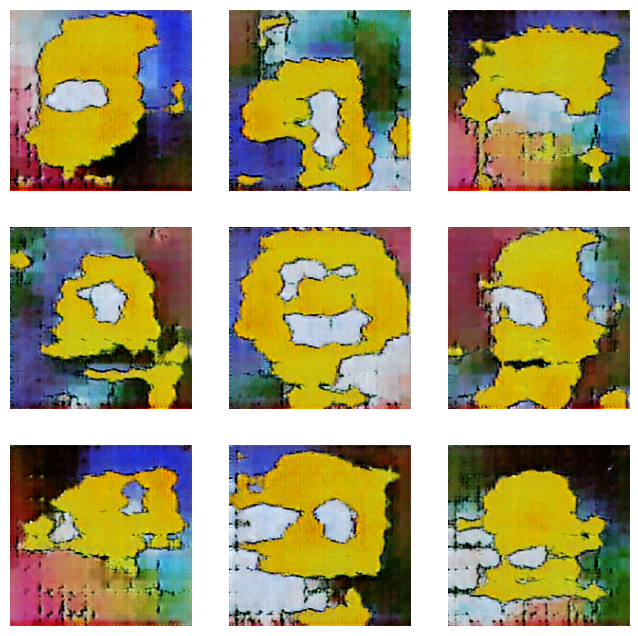

309/309 [==============================] - 41s 133ms/step - d_loss: 0.0381 - g_loss: 7.4652
Epoch 32/50
309/309 [==============================] - 41s 132ms/step - d_loss: 0.0374 - g_loss: 6.7181
Epoch 33/50
309/309 [==============================] - 41s 132ms/step - d_loss: 0.0200 - g_loss: 7.0139
Epoch 34/50
309/309 [==============================] - 41s 132ms/step - d_loss: 0.0412 - g_loss: 7.1720
Epoch 35/50
309/309 [==============================] - 41s 132ms/step - d_loss: -0.0058 - g_loss: 7.1528
Epoch 36/50
309/309 [==============================] - 41s 132ms/step - d_loss: 0.0121 - g_loss: 7.6336
Epoch 37/50
309/309 [==============================] - 41s 132ms/step - d_loss: 0.0086 - g_loss: 7.3974
Epoch 38/50
309/309 [==============================] - 41s 132ms/step - d_loss: -0.0065 - g_loss: 6.8999
Epoch 39/50
309/309 [==============================] - 41s 132ms/step - d_loss: 0.0065 - g_loss: 7.0514
Epoch 40/50
309/309 [==============================] - 41s 132ms/step - d_

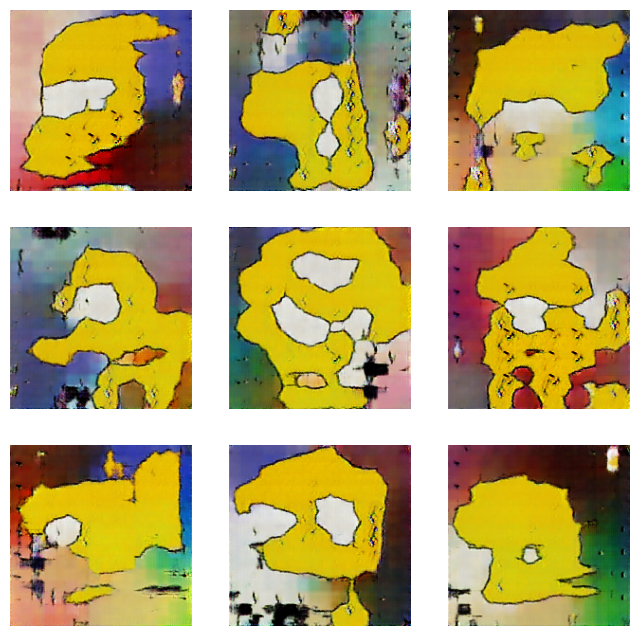

309/309 [==============================] - 41s 134ms/step - d_loss: -0.0070 - g_loss: 7.0248
Epoch 42/50
309/309 [==============================] - 41s 132ms/step - d_loss: 0.0232 - g_loss: 7.1441
Epoch 43/50
309/309 [==============================] - 41s 132ms/step - d_loss: 0.0311 - g_loss: 7.9439
Epoch 44/50
309/309 [==============================] - 41s 132ms/step - d_loss: -0.0189 - g_loss: 6.6939
Epoch 45/50
309/309 [==============================] - 41s 132ms/step - d_loss: -0.0192 - g_loss: 6.8304
Epoch 46/50
309/309 [==============================] - 41s 132ms/step - d_loss: 0.0134 - g_loss: 7.1139
Epoch 47/50
309/309 [==============================] - 41s 132ms/step - d_loss: -0.0219 - g_loss: 7.2391
Epoch 48/50
309/309 [==============================] - 41s 132ms/step - d_loss: -0.0354 - g_loss: 6.8860
Epoch 49/50
309/309 [==============================] - 41s 132ms/step - d_loss: 0.0537 - g_loss: 8.3894
Epoch 50/50
309/309 [==============================] - 41s 132ms/step -

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
N_EPOCHS = 50
dcgan.fit(images, epochs=N_EPOCHS, callbacks=[DCGANMonitor()])

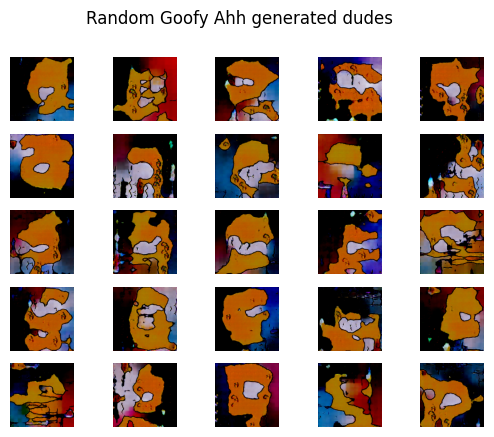

In [36]:
random_noise = list([tf.random.normal([1, 100]) for i in range(25)])
pred = []
for i in range(len(random_noise)):
    pred.append(generator.predict(random_noise[i], verbose=0))

plt.suptitle('Random Goofy Ahh generated dudes')
for i in range(len(random_noise)):
    plt.subplot(int(np.sqrt(len(random_noise))), int(np.sqrt(len(random_noise))), i + 1)
    plt.axis('off')
    plt.imshow(pred[i][0]);

# **Well they are yellow...** <br>
Damn they look like that melted Homer: <br>
<img src='https://media1.tenor.com/m/d49Rc2qtMGgAAAAd/homer-how-bout-a-hug.gif'>